In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.data import Dataset
from src.covariance import compute_cov
import sklearn

### Loading dataset

In [2]:
# Loads raw data, and processes it if not already processed
dataset = Dataset('/Users/mehdiazabou/Documents/Nerds/cell_type/data', force_process=False)

Found processed pickle. Loading from '/Users/mehdiazabou/Documents/Nerds/cell_type/data/processed/dataset.pkl'.


### Aggregating cell types

In [3]:
# List cell types
print(dataset.cell_type_labels)
print('Before aggregation: Number of cell types -', dataset.num_cell_types)

# this dict defines how cell types are grouped
aggr_dict = {'e23Cux2': 'e23', 'i5Sst': 'i5Sst', 'i5Htr3a': 'i5Htr3a', 'e4Scnn1a': 'e4', 'e4Rorb': 'e4',
             'e4other': 'e4', 'e4Nr5a1': 'e4', 'i6Htr3a': 'i6Htr3a', 'i6Sst': 'i6Sst', 'e6Ntsr1': 'e6',
             'i23Pvalb': 'i23Pvalb', 'i23Htr3a': 'i23Htr3a', 'i1Htr3a': 'i1Htr3a', 'i4Sst': 'i4Sst', 'e5Rbp4': 'e5',
             'e5noRbp4': 'e5', 'i23Sst': 'i23Sst', 'i4Htr3a': 'i4Htr3a', 'i6Pvalb': 'i6Pvalb', 'i5Pvalb': 'i5Pvalb',
             'i4Pvalb': 'i4Pvalb'}

dataset.aggregate_cell_classes(aggr_dict)
print('After aggregation: Number of cell types -', dataset.num_cell_types)

['e5Rbp4', 'e23Cux2', 'i6Pvalb', 'e4Scnn1a', 'i23Pvalb', 'i6Htr3a', 'i23Htr3a', 'e4Rorb', 'i5Htr3a', 'e4other', 'i5Pvalb', 'i4Pvalb', 'i23Sst', 'i4Htr3a', 'i4Sst', 'e4Nr5a1', 'i1Htr3a', 'i5Sst', 'e5noRbp4', 'i6Sst', 'e6Ntsr1']
Before aggregation: Number of cell types - 21
After aggregation: Number of cell types - 17


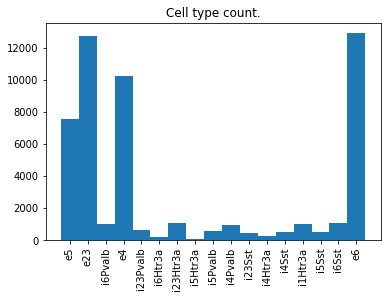

In [4]:
plt.hist(dataset.cell_type_ids, bins=np.arange(-0.5, dataset.num_cell_types, 1))
plt.xticks(np.arange(dataset.num_cell_types), dataset.cell_type_labels, rotation='vertical')
plt.title('Cell type count.')
plt.show()

### Split into train/val/test sets

In [5]:
# first, we split the population of neurons into three subsets
# the split is startified, i.e. the cell types are balanced across classes
# Note: The split can be done before the aggregation so that diverse cells are present in all subsets.
dataset.split_cell_train_val_test(test_size=0.2, val_size=0.2, seed=1234)

# next, the trial are temporally split
dataset.split_trial_train_val_test(test_size=0.2, val_size=0.2, temp=True, seed=1234)

### Define binning (and streaming [WIP]) parameters

In [6]:
dataset.set_bining_parameters(bin_size=100e-3)  # in seconds, so this is 10ms

### Sample populations of neurons!
Currently when sampling populations, a fixed number of cells are sampled for each cell type

##### To select a random population in a random trial

In [7]:
X, y, m = dataset.sample(mode='train', sampler='U10')
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Firing rates matrix shape: (30, 170)
Trial id: 35, Orientation: 315.0


##### To change the number of samples per class, use `sampler=U60` to get 60 cells per cell type.
Note: Some cell types have fewer than 20 cells (across all split sets), so currently max is 20

In [8]:
X, y, m = dataset.sample(mode='train', sampler='U20')
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Firing rates matrix shape: (30, 340)
Trial id: 44, Orientation: 270.0


##### Fixing the population and randomly sampling the trial
Use cell_random_seed

In [9]:
X, y, m = dataset.sample(mode='train', sampler='U20', cell_random_seed=40)
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Firing rates matrix shape: (30, 340)
Trial id: 10, Orientation: 225.0


##### Fixing the trial and randomly sampling the population
Use trial_random_seed or trial_id

In [10]:
# select trial
X, y, m = dataset.sample(mode='train', sampler='U20', trial_id=18)
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

# fix trial random seed
X, y, m = dataset.sample(mode='train', sampler='U20', trial_random_seed=1)
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

X, y, m = dataset.sample(mode='train', sampler='U20', trial_random_seed=1)
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Firing rates matrix shape: (30, 340)
Trial id: 18, Orientation: 315.0
Firing rates matrix shape: (30, 340)
Trial id: 37, Orientation: 180.0
Firing rates matrix shape: (30, 340)
Trial id: 37, Orientation: 180.0


##### Switch between train/val/test sets

In [11]:
X, y, m = dataset.sample(mode='test', sampler='U20')
print('Firing rates matrix shape:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))


Firing rates matrix shape: (30, 340)
Trial id: 87, Orientation: 270.0


# Compute covariance

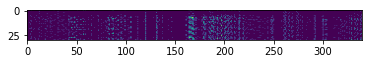

In [12]:
X, y, m = dataset.sample(mode='train', sampler='U20')

plt.imshow(X)
plt.show()


##### Raw data

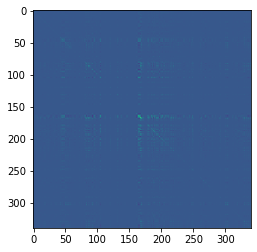

In [13]:
cov = compute_cov(X.T)
plt.imshow(cov)
plt.show()

##### Divide by max

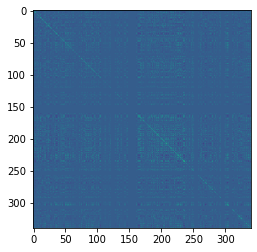

In [14]:
cov = compute_cov(X.T, scaler=sklearn.preprocessing.MaxAbsScaler)
plt.imshow(cov)
plt.show()

##### Zero-score

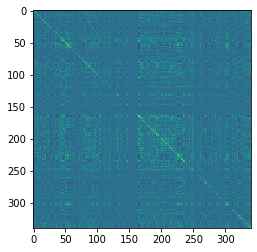

In [15]:
cov = compute_cov(X.T, scaler=sklearn.preprocessing.StandardScaler)
plt.imshow(cov)
plt.show()


### Compute edge distribution

In [16]:
def compute_edge_dist(cov, num_bins=10, vmin=0, vmax=1.):
    bins = np.linspace(vmin, vmax, num_bins+1)
    return np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, cov)

compute_edge_dist(cov).shape

(340, 10)